In [1]:
# Import necessary libraries for preprocessing
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn.model_selection as ms
from sklearn import tree
from sklearn.model_selection import GridSearchCV
from sklearn import ensemble
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold

# Load the dataset
#Atlanta_Distance = pd.read_pickle(r'~/Documents/NYCDSA/Capstone/Pickle Files/Atlanta_Nearest_POI.pkl')
Atlanta_Density = pd.read_csv('~/Documents/NYCDSA/Capstone/Density_Atlanta/Density_Atlanta.csv')
Atlanta_Density['Total Bathrooms'] = Atlanta_Density['number_of_full_baths'] + (Atlanta_Density['number_of_half_baths']*0.5)
Atlanta_Density = Atlanta_Density.drop(columns=['latitude',
                                                  'longitude', 'number_of_full_baths', 'number_of_half_baths',
                                                  	'street_address'])
Atlanta_Density = Atlanta_Density.rename(columns={'SM_One': 'Supermarket (One Mile)', 'C_One': 'Convenience (One Mile)',
'WS_One': 'Wholesale (One Mile)', 'VS_One': 'Variety Store (One Mile)', 'SC_One': 'Supercenter (One Mile)', 'number_of_bedrooms': 'Total Bedrooms', 'living_area_square_feet': 'Living Area(SQF)',
                                                   'lot_size_in_square_feet': 'Lot Size(SQF)', 'number_of_garage_spaces': 'Garage Spaces', 'number_of_stories': 'Stories',
                                                   'SM_Five': 'Supermarket (Five Miles)', 'C_Five': 'Convenience (Five Miles)', 'year_built': 'Year Built',
'WS_Five': 'Wholesale (Five Miles)', 'VS_Five': 'Variety Store (Five Miles)', 'SC_Five': 'Supercenter (Five Miles)',
                                                 'WS_Three': 'Wholesale (Three Miles)', 'VS_Three': 'Variety Store (Three Miles)',
                                                  'SM_Three': 'Supermarket (Three Miles)', 'SC_Three': 'Supercenter (Three Miles)', 'C_Three': 'Convenience (Three Miles)'})
Atlanta_Density['Year Built'] = Atlanta_Density['Year Built'].astype('Int64') #For numerical analysis: Use int or float if there are missing values
Atlanta_Density_One = Atlanta_Density.drop(columns=['Wholesale (Five Miles)', 'Variety Store (Five Miles)', 'Supermarket (Five Miles)', 'Supercenter (Five Miles)', 'Convenience (Five Miles)',
                                                   'Wholesale (Three Miles)','Variety Store (Three Miles)','Supermarket (Three Miles)', 'Supercenter (Three Miles)','Convenience (Three Miles)'])
Atlanta_Density_One

,current_listing_price,Year Built,Total Bedrooms,Living Area(SQF),Convenience (One Mile),Supercenter (One Mile),Supermarket (One Mile),Variety Store (One Mile),Wholesale (One Mile),Total Bathrooms
0,2865,2002,4,3259.0,0,0,0,0,0,2.5
1,2200,<NA>,3,1993.0,2,1,0,2,0,2.0
2,2000,<NA>,3,1910.0,0,0,0,0,0,2.0
3,1995,<NA>,3,1134.0,0,0,0,0,0,1.0
4,2800,<NA>,4,2532.0,0,0,0,0,0,2.0
...,...,...,...,...,...,...,...,...,...,...
21010,1600,<NA>,3,1367.0,0,0,0,0,0,2.0
21011,2199,<NA>,3,1696.0,1,0,1,0,0,2.5
21012,2380,2015,3,1944.0,0,1,1,1,1,3.5
21013,1900,<NA>,4,1204.0,1,0,0,1,0,2.0


In [2]:
# Exclude 'current_listing_price' from features
numeric_features = Atlanta_Density_One.select_dtypes(include=['int64', 'float64']).drop(columns=['current_listing_price']).columns
#categorical_features = list(Atlanta_Distance.columns[Atlanta_Distance.dtypes == 'object'])

In [3]:
# Helper function to fill 'None' for missing categorical data
def fill_none(X):
    return X.fillna("None")

# Pipeline for numeric features: Impute missing values using mean
numeric_transformer = Pipeline(steps=[
    ('impute_mean', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Pipeline for nominal categorical features: Fill missing values with 'None' then apply one-hot encoding
#categorical_transformer = Pipeline(steps=[
    #('impute_none', SimpleImputer(strategy='constant', fill_value='None')),  # Using SimpleImputer
    #('onehot', OneHotEncoder(handle_unknown='ignore'))
#])

# Combined preprocessor for numeric and nominal
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        #('nominal', categorical_transformer, categorical_features)
])

transformed_data = preprocessor.fit_transform(Atlanta_Density_One)

In [4]:
# Generate column names for the one-hot encoded features
#onehot_features = preprocessor.named_transformers_['nominal'].named_steps['onehot'].get_feature_names_out()
# Combine all feature names
all_feature_names = list(numeric_features)
all_feature_names

['Year Built',
 'Total Bedrooms',
 'Living Area(SQF)',
 'Convenience (One Mile)',
 'Supercenter (One Mile)',
 'Supermarket (One Mile)',
 'Variety Store (One Mile)',
 'Wholesale (One Mile)',
 'Total Bathrooms']

In [5]:
transformed_df = pd.DataFrame(transformed_data, columns=all_feature_names)
transformed_df

,Year Built,Total Bedrooms,Living Area(SQF),Convenience (One Mile),Supercenter (One Mile),Supermarket (One Mile),Variety Store (One Mile),Wholesale (One Mile),Total Bathrooms
0,5.031097e-01,0.641662,1.314310,-0.376706,-0.229536,-0.527769,-0.411410,-0.093726,0.177326
1,-1.091762e-14,-0.459475,0.111774,1.973794,3.756991,-0.527769,2.856081,-0.093726,-0.475680
2,-1.091762e-14,-0.459475,0.032935,-0.376706,-0.229536,-0.527769,-0.411410,-0.093726,-0.475680
3,-1.091762e-14,-0.459475,-0.704165,-0.376706,-0.229536,-0.527769,-0.411410,-0.093726,-1.781691
4,-1.091762e-14,0.641662,0.623754,-0.376706,-0.229536,-0.527769,-0.411410,-0.093726,-0.475680
...,...,...,...,...,...,...,...,...,...
21010,-1.091762e-14,-0.459475,-0.482845,-0.376706,-0.229536,-0.527769,-0.411410,-0.093726,-0.475680
21011,-1.091762e-14,-0.459475,-0.170338,0.798544,-0.229536,0.857576,-0.411410,-0.093726,0.177326
21012,1.127320e+00,-0.459475,0.065230,-0.376706,3.756991,0.857576,1.222336,10.669399,1.483337
21013,-1.091762e-14,0.641662,-0.637674,0.798544,-0.229536,-0.527769,1.222336,-0.093726,-0.475680


In [6]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
# Assuming RandomForest is part of your models dictionary
random_forest_model = RandomForestRegressor(random_state = 42)
# Define the full model pipeline including the preprocessor and RandomForestRegressor
random_forest_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', random_forest_model)
])
X = Atlanta_Density_One.drop(columns='current_listing_price')
y = Atlanta_Density_One['current_listing_price']

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)

# Fit the model pipeline
random_forest_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('impute_mean',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['Year Built', 'Total Bedrooms', 'Living Area(SQF)',
       'Convenience (One Mile)', 'Supercenter (One Mile)',
       'Supermarket (One Mile)', 'Variety Store (One Mile)',
       'Wholesale (One Mile)', 'Total Bathrooms'],
      dtype='object'))])),
                ('regressor', RandomForestRegressor(random_state=42))])

In [7]:
val_score = random_forest_pipeline.score(X_val, y_val) #0.6137914878103629
print('Validation R^2:', val_score)

test_score = random_forest_pipeline.score(X_test, y_test) #0.55202185736604
print('Test R^2:', test_score)

Validation R^2: 0.45780285065093773
Test R^2: 0.48770741436595744


In [8]:
from sklearn.metrics import mean_squared_error 
y_val_pred = random_forest_pipeline.predict(X_val)

val_mse = mean_squared_error(y_val, y_val_pred)
print('Validation Mean Squared Error:', val_mse)
val_rmse = np.sqrt(val_mse)
print("Validation Root Mean Squared Error:", val_rmse)

y_test_pred = random_forest_pipeline.predict(X_test)

test_mse = mean_squared_error(y_test, y_test_pred)
print('Test Mean Squared Error:', test_mse)
test_rmse = np.sqrt(test_mse)
print("Test Root Mean Squared Error:", test_rmse)

Validation Mean Squared Error: 452673.00252622867
Validation Root Mean Squared Error: 672.8097818300716
Test Mean Squared Error: 437310.80009301717
Test Root Mean Squared Error: 661.2947906138511


In [9]:
def calculate_mape(actual, predicted):
    actual, predicted = np.array(actual), np.array(predicted)
    mape = np.mean(np.abs((actual - predicted) / actual)) * 100
    return mape

val_mape = calculate_mape(y_val, y_val_pred)
test_mape = calculate_mape(y_test, y_test_pred)

print("Validation Mean Absolute Percentage Error (MAPE):", val_mape)
print("Test Mean Absolute Percentage Error (MAPE):", test_mape) #A lower MAPE value indicates a more accurate prediction

Validation Mean Absolute Percentage Error (MAPE): 16.86245941236647
Test Mean Absolute Percentage Error (MAPE): 17.106159965860986


In [21]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score, root_mean_squared_error
params = {
    'regressor__n_estimators': [1000],
    'regressor__max_depth': [8],
    'regressor__min_samples_split': [2],
    'regressor__min_samples_leaf': [1],
    'regressor__max_features': ['sqrt'],
}
random_forest_search = GridSearchCV(
    estimator=random_forest_pipeline,
    param_grid=params,
    scoring=['r2', 'neg_mean_squared_error', 'neg_mean_absolute_percentage_error', 'neg_root_mean_squared_error'],# Multiple scoring
    refit='r2',
    cv=10,  # Number of cross-validation folds
    n_jobs=-1,  # Use all available cores
    verbose=2,
)

# Fit RandomizedSearchCV
random_forest_search.fit(X_train, y_train)

best_model = random_forest_search.best_estimator_

# Access the results
results = random_forest_search.cv_results_
print("Best parameters:", random_forest_search.best_params_)
print("Best R^2:", random_forest_search.best_score_)


mean_r2_scores = results['mean_test_r2']
mean_mse_scores = -results['mean_test_neg_mean_squared_error']
mean_mape_scores = -results['mean_test_neg_mean_absolute_percentage_error']
mean_RMSE_scores = -results['mean_test_neg_root_mean_squared_error']

print("Mean MSE scores:", mean_mse_scores)
print("Mean MAPE scores:", mean_mape_scores)
print("Mean R^2 scores:", mean_r2_scores)
print("Mean RMSE scores:", mean_RMSE_scores)

Fitting 10 folds for each of 1 candidates, totalling 10 fits
Best parameters: {'regressor__max_depth': 8, 'regressor__max_features': 'sqrt', 'regressor__min_samples_leaf': 1, 'regressor__min_samples_split': 2, 'regressor__n_estimators': 1000}
Best R^2: 0.47805637585309946
Mean MSE scores: [427924.52536304]
Mean MAPE scores: [0.17083455]
Mean R^2 scores: [0.47805638]
Mean RMSE scores: [653.27147126]


In [22]:
def calculate_scores(y_true, y_pred):
    r2 = r2_score(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    rmse = root_mean_squared_error(y_true, y_pred)
    return r2, mse, mape, rmse

In [23]:
y_val_pred_tuned = best_model.predict(X_val)
val_scores = calculate_scores(y_val, y_val_pred_tuned)

y_test_pred_tuned = best_model.predict(X_test)
test_scores = calculate_scores(y_test, y_test_pred_tuned)

y_combined_pred_tuned = best_model.predict(X_train_val)
combined_scores = calculate_scores(y_train_val, y_combined_pred_tuned)

print("Tuned Validation Set Scores:")
print(f"R²: {val_scores[0]:.4f}")
print(f"MSE: {val_scores[1]:.4f}")
print(f"MAPE: {val_scores[2]:.4f}")
print(f"RMSE: {val_scores[3]:.4f}")

print("\nTuned Test Set Scores:")
print(f"R²: {test_scores[0]:.4f}")
print(f"MSE: {test_scores[1]:.4f}")
print(f"MAPE: {test_scores[2]:.4f}")
print(f"RMSE: {test_scores[3]:.4f}")

print("\nTuned Test-Val Set Scores:")
print(f"R²: {combined_scores[0]:.4f}")
print(f"MSE: {combined_scores[1]:.4f}")
print(f"MAPE: {combined_scores[2]:.4f}")
print(f"RMSE: {combined_scores[3]:.4f}")
#Refitted model may be causing data leakage, and therefore different results. Differences can be ignored

Tuned Validation Set Scores:
R²: 0.4630
MSE: 448322.1936
MAPE: 0.1690
RMSE: 669.5687

Tuned Test Set Scores:
R²: 0.4801
MSE: 443811.2740
MAPE: 0.1716
RMSE: 666.1916

Tuned Test-Val Set Scores:
R²: 0.5583
MSE: 364216.0566
MAPE: 0.1628
RMSE: 603.5032


In [24]:
best_forest_model = best_model.named_steps['regressor']
feature_importances = best_forest_model.feature_importances_

In [25]:
sorted_indices = np.argsort(feature_importances)[::-1]
sorted_feature_importances = feature_importances[sorted_indices]
sorted_feature_names = np.array(all_feature_names)[sorted_indices]

In [26]:
for name, importance in zip(sorted_feature_names, sorted_feature_importances):
    print(f"Feature: {name}, Importance: {importance:.4f}")

Feature: Living Area(SQF), Importance: 0.3829
Feature: Total Bathrooms, Importance: 0.2460
Feature: Year Built, Importance: 0.1237
Feature: Total Bedrooms, Importance: 0.1060
Feature: Convenience (One Mile), Importance: 0.0641
Feature: Supermarket (One Mile), Importance: 0.0560
Feature: Variety Store (One Mile), Importance: 0.0140
Feature: Supercenter (One Mile), Importance: 0.0068
Feature: Wholesale (One Mile), Importance: 0.0004


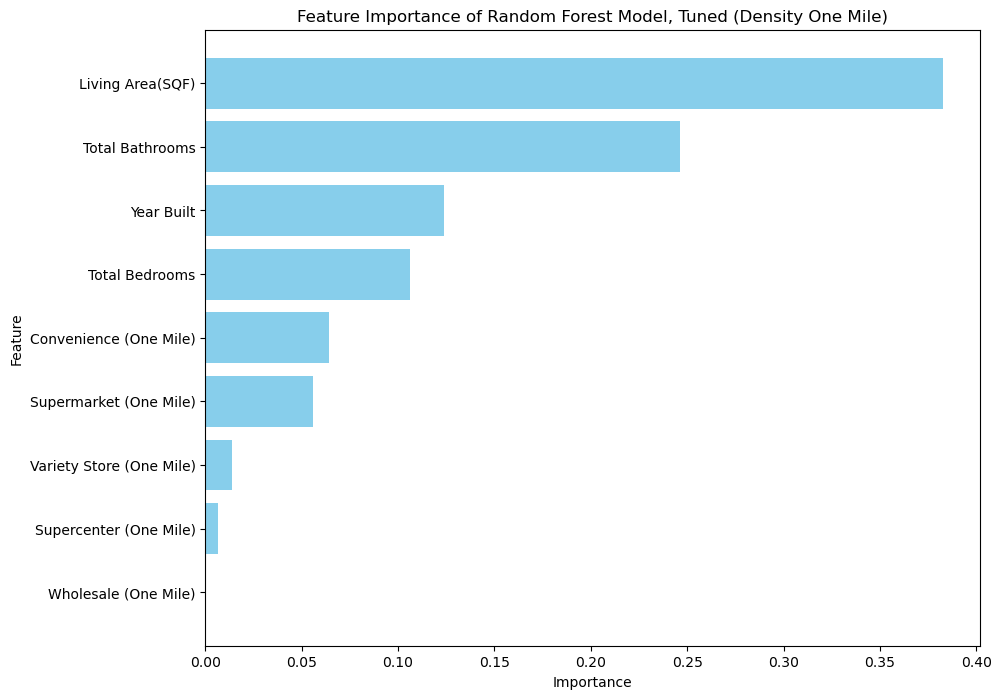

In [27]:
# Create a bar chart for feature importance
plt.figure(figsize=(10, 8))
plt.barh(sorted_feature_names, sorted_feature_importances, color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance of Random Forest Model, Tuned (Density One Mile)')
plt.gca().invert_yaxis()  # Invert y-axis to show the most important feature at the top
plt.show()

#The feature importance scores remain consistent regardless of the dataset.

In [28]:
all_feature_names

['Year Built',
 'Total Bedrooms',
 'Living Area(SQF)',
 'Convenience (One Mile)',
 'Supercenter (One Mile)',
 'Supermarket (One Mile)',
 'Variety Store (One Mile)',
 'Wholesale (One Mile)',
 'Total Bathrooms']

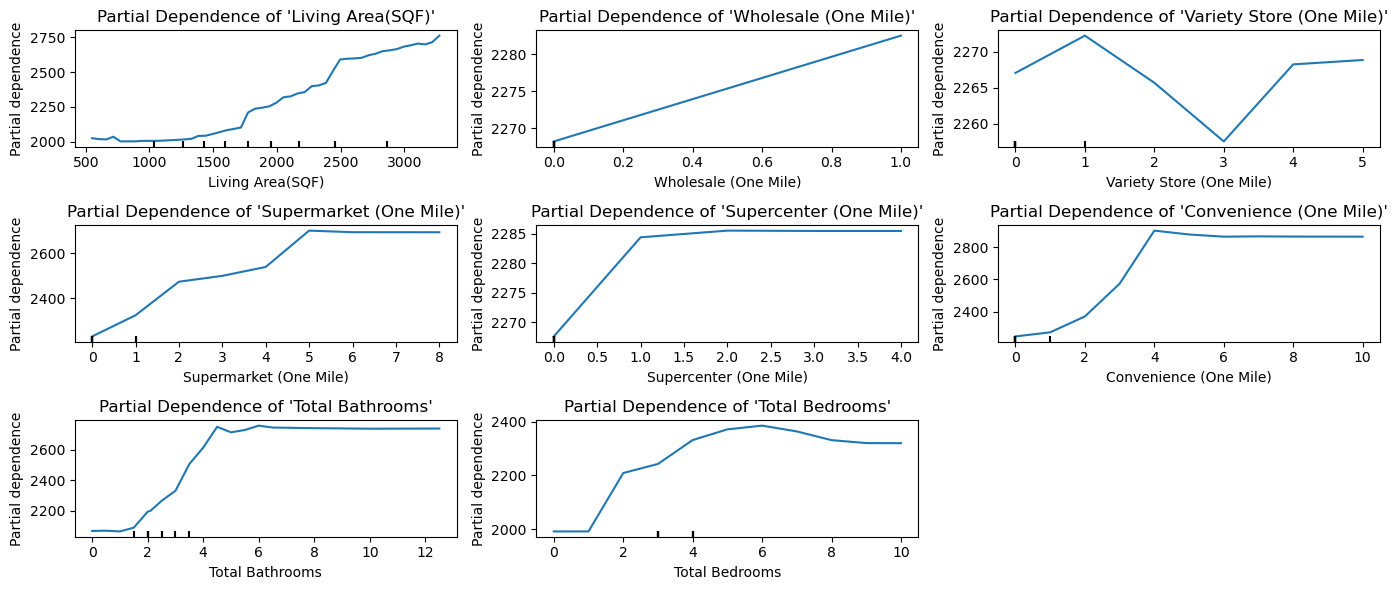

In [29]:
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt
import math

# List of features to include in the Partial Dependence Plots
features = [
 'Living Area(SQF)', 'Wholesale (One Mile)', 'Variety Store (One Mile)', 'Supermarket (One Mile)', 
    'Supercenter (One Mile)', 'Convenience (One Mile)', 'Total Bathrooms', 'Total Bedrooms']

# Set the number of rows and columns for the grid
n_features = len(features)
n_cols = 3  # Number of columns in the grid
n_rows = math.ceil(n_features / n_cols)  # Number of rows

# Create subplots in a grid layout
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(14, n_rows * 2))

# Flatten axes for easy iteration
axes = axes.ravel()

# Loop through each feature and plot
for i, feature in enumerate(features):
    PartialDependenceDisplay.from_estimator(
        best_model,
        X_train,  # train data?
        [feature],
        grid_resolution=50,
        ax=axes[i]
    )
    axes[i].set_title(f"Partial Dependence of '{feature}'")  # Set title for each plot

# Hide any empty subplots (if n_features is not a perfect square)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout to avoid overlap
plt.tight_layout()
plt.show()

In [30]:
Atlanta_Density_Three = Atlanta_Density.drop(columns=['Wholesale (One Mile)', 'Variety Store (One Mile)', 'Supermarket (One Mile)', 'Supercenter (One Mile)', 'Convenience (One Mile)',
                                                      'Wholesale (Five Miles)', 'Variety Store (Five Miles)', 'Supermarket (Five Miles)', 'Supercenter (Five Miles)', 'Convenience (Five Miles)'])
numeric_features_three = Atlanta_Density_Three.select_dtypes(include=['int64', 'float64']).drop(columns=['current_listing_price']).columns
# Helper function to fill 'None' for missing categorical data
def fill_none(X):
    return X.fillna("None")

# Pipeline for numeric features: Impute missing values using mean
numeric_transformer_three = Pipeline(steps=[
    ('impute_mean', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Combined preprocessor for numeric and nominal
preprocessor_three = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer_three, numeric_features_three),
        #('nominal', categorical_transformer, categorical_features)
])

transformed_data_three = preprocessor_three.fit_transform(Atlanta_Density_Three)

In [31]:
# Combine all feature names
all_feature_names_three = list(numeric_features_three)
transformed_df_three = pd.DataFrame(transformed_data_three, columns=all_feature_names_three)

In [32]:
# Assuming RandomForest is part of your models dictionary
random_forest_model_three = RandomForestRegressor(random_state = 42)
# Define the full model pipeline including the preprocessor and RandomForestRegressor
random_forest_pipeline_three = Pipeline([
    ('preprocessor', preprocessor_three),
    ('regressor', random_forest_model_three)
])
X_three = Atlanta_Density_Three.drop(columns='current_listing_price')
y_three = Atlanta_Density_Three['current_listing_price']

X_train_val_three, X_test_three, y_train_val_three, y_test_three = train_test_split(X_three, y_three, test_size=0.2, random_state=42)
X_train_three, X_val_three, y_train_three, y_val_three = train_test_split(X_train_val_three, y_train_val_three, test_size=0.25, random_state=42)

# Fit the model pipeline
random_forest_pipeline_three.fit(X_train_three, y_train_three)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('impute_mean',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['Year Built', 'Total Bedrooms', 'Living Area(SQF)',
       'Wholesale (Three Miles)', 'Variety Store (Three Miles)',
       'Supermarket (Three Miles)', 'Supercenter (Three Miles)',
       'Convenience (Three Miles)', 'Total Bathrooms'],
      dtype='object'))])),
                ('regressor', RandomForestRegressor(random_state=42))])

In [33]:
val_score_three = random_forest_pipeline_three.score(X_val_three, y_val_three)
print('Validation R^2:', val_score_three)

test_score_three = random_forest_pipeline_three.score(X_test_three, y_test_three)
print('Test R^2:', test_score_three)

Validation R^2: 0.5920912754886267
Test R^2: 0.5899104985983539


In [36]:
from sklearn.model_selection import RandomizedSearchCV

# Define the parameter grid for Random Forest
params_three = {
    'regressor__n_estimators': [800],
    'regressor__max_depth': [8],
    'regressor__min_samples_split': [2],
    'regressor__min_samples_leaf': [1],
    'regressor__max_features': ['sqrt'],
}

# Set up RandomizedSearchCV
random_forest_search_three = GridSearchCV(
    estimator=random_forest_pipeline_three,
    param_grid=params_three,
    scoring=['r2', 'neg_mean_squared_error', 'neg_mean_absolute_percentage_error', 'neg_root_mean_squared_error'],# Multiple scoring
    refit='r2',
    cv=10,  # Number of cross-validation folds
    n_jobs=-1,  # Use all available cores
    verbose=2,
)

# Fit RandomizedSearchCV
random_forest_search_three.fit(X_train_three, y_train_three)

best_model_three = random_forest_search_three.best_estimator_

# Access the results
results_three = random_forest_search_three.cv_results_
print("Best parameters:", random_forest_search_three.best_params_)
print("Best R^2:", random_forest_search_three.best_score_)


mean_r2_scores_three = results_three['mean_test_r2']
mean_mse_scores_three = -results_three['mean_test_neg_mean_squared_error']
mean_mape_scores_three = -results_three['mean_test_neg_mean_absolute_percentage_error']
mean_RMSE_scores_three = -results_three['mean_test_neg_root_mean_squared_error']

print("Mean MSE scores:", mean_mse_scores_three)
print("Mean MAPE scores:", mean_mape_scores_three)
print("Mean R^2 scores:", mean_r2_scores_three)
print("Mean RMSE scores:", mean_RMSE_scores_three)

Fitting 10 folds for each of 1 candidates, totalling 10 fits
Best parameters: {'regressor__max_depth': 8, 'regressor__max_features': 'sqrt', 'regressor__min_samples_leaf': 1, 'regressor__min_samples_split': 2, 'regressor__n_estimators': 800}
Best R^2: 0.5554205146005881
Mean MSE scores: [364564.5962939]
Mean MAPE scores: [0.15794851]
Mean R^2 scores: [0.55542051]
Mean RMSE scores: [602.72841395]


In [37]:
y_val_pred_tuned_three = best_model_three.predict(X_val_three)
val_scores_three = calculate_scores(y_val_three, y_val_pred_tuned_three)

y_test_pred_tuned_three = best_model_three.predict(X_test_three)
test_scores_three = calculate_scores(y_test_three, y_test_pred_tuned_three)

y_combined_pred_tuned_three = best_model_three.predict(X_train_val_three)
combined_scores_three = calculate_scores(y_train_val_three, y_combined_pred_tuned_three)

print("Tuned Validation Set Scores:")
print(f"R²: {val_scores_three[0]:.4f}")
print(f"MSE: {val_scores_three[1]:.4f}")
print(f"MAPE: {val_scores_three[2]:.4f}")
print(f"RMSE: {val_scores_three[3]:.4f}")

print("\nTuned Test Set Scores:")
print(f"R²: {test_scores_three[0]:.4f}")
print(f"MSE: {test_scores_three[1]:.4f}")
print(f"MAPE: {test_scores_three[2]:.4f}")
print(f"RMSE: {test_scores_three[3]:.4f}")

print("\nTuned Test-Val Set Scores:")
print(f"R²: {combined_scores_three[0]:.4f}")
print(f"MSE: {combined_scores_three[1]:.4f}")
print(f"MAPE: {combined_scores_three[2]:.4f}")
print(f"RMSE: {combined_scores_three[3]:.4f}")

Tuned Validation Set Scores:
R²: 0.5635
MSE: 364454.9084
MAPE: 0.1554
RMSE: 603.7010

Tuned Test Set Scores:
R²: 0.5486
MSE: 385329.8807
MAPE: 0.1586
RMSE: 620.7495

Tuned Test-Val Set Scores:
R²: 0.6405
MSE: 296433.2675
MAPE: 0.1493
RMSE: 544.4569


In [38]:
best_forest_model_three = best_model_three.named_steps['regressor']
feature_importances_three = best_forest_model_three.feature_importances_
sorted_indices_three = np.argsort(feature_importances_three)[::-1]
sorted_feature_importances_three = feature_importances_three[sorted_indices_three]
sorted_feature_names_three = np.array(all_feature_names_three)[sorted_indices_three]
for name, importance in zip(sorted_feature_names_three, sorted_feature_importances_three):
    print(f"Feature: {name}, Importance: {importance:.4f}")

Feature: Living Area(SQF), Importance: 0.3355
Feature: Total Bathrooms, Importance: 0.2057
Feature: Supermarket (Three Miles), Importance: 0.1443
Feature: Total Bedrooms, Importance: 0.0932
Feature: Convenience (Three Miles), Importance: 0.0888
Feature: Year Built, Importance: 0.0888
Feature: Variety Store (Three Miles), Importance: 0.0242
Feature: Supercenter (Three Miles), Importance: 0.0171
Feature: Wholesale (Three Miles), Importance: 0.0023


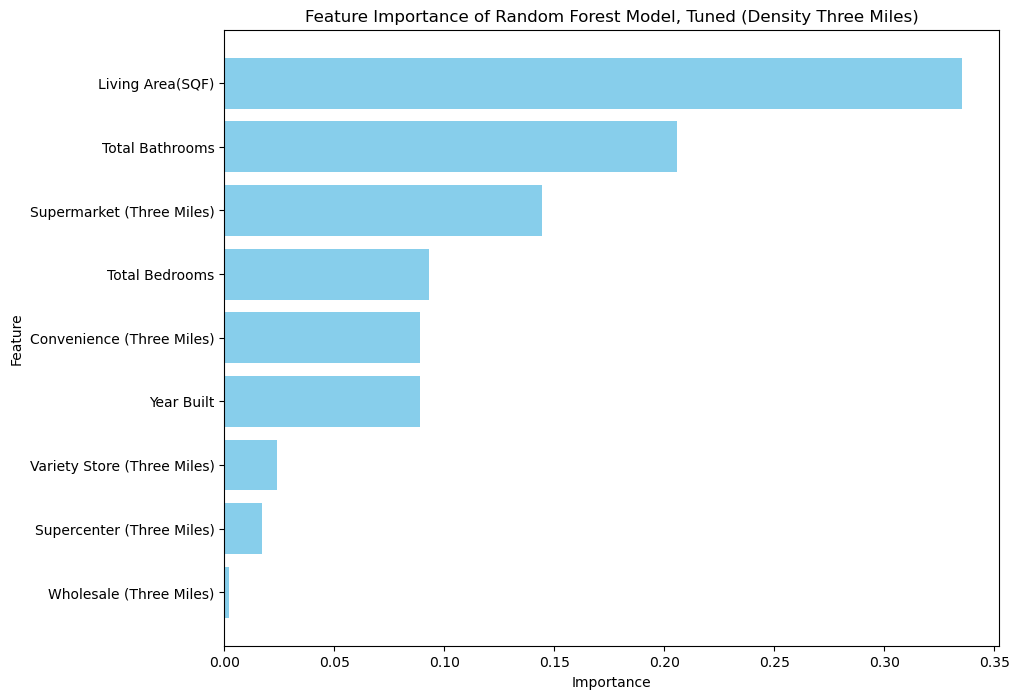

In [39]:
# Create a bar chart for feature importance
plt.figure(figsize=(10, 8))
plt.barh(sorted_feature_names_three, sorted_feature_importances_three, color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance of Random Forest Model, Tuned (Density Three Miles)')
plt.gca().invert_yaxis()  # Invert y-axis to show the most important feature at the top
plt.show()

#The feature importance scores remain consistent regardless of the dataset.

In [40]:
all_feature_names_three

['Year Built',
 'Total Bedrooms',
 'Living Area(SQF)',
 'Wholesale (Three Miles)',
 'Variety Store (Three Miles)',
 'Supermarket (Three Miles)',
 'Supercenter (Three Miles)',
 'Convenience (Three Miles)',
 'Total Bathrooms']

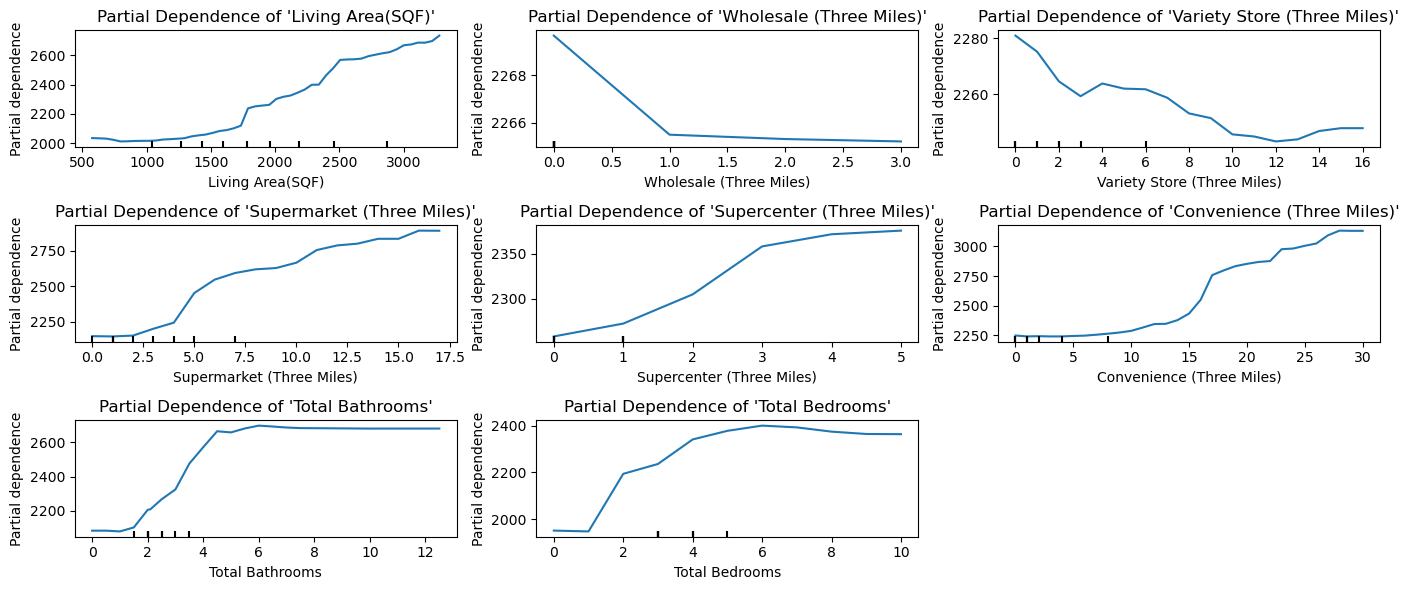

In [41]:
# List of features to include in the Partial Dependence Plots
features = [
'Living Area(SQF)', 'Wholesale (Three Miles)', 'Variety Store (Three Miles)', 'Supermarket (Three Miles)', 
    'Supercenter (Three Miles)', 'Convenience (Three Miles)', 'Total Bathrooms', 'Total Bedrooms']

# Set the number of rows and columns for the grid
n_features = len(features)
n_cols = 3  # Number of columns in the grid
n_rows = math.ceil(n_features / n_cols)  # Number of rows

# Create subplots in a grid layout
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(14, n_rows * 2))

# Flatten axes for easy iteration
axes = axes.ravel()

# Loop through each feature and plot
for i, feature in enumerate(features):
    PartialDependenceDisplay.from_estimator(
        best_model_three,
        X_train_val_three,  # train data?
        [feature],
        grid_resolution=50,
        ax=axes[i]
    )
    axes[i].set_title(f"Partial Dependence of '{feature}'")  # Set title for each plot

# Hide any empty subplots (if n_features is not a perfect square)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout to avoid overlap
plt.tight_layout()
plt.show()

In [42]:
Atlanta_Density_Five = Atlanta_Density.drop(columns=['Wholesale (One Mile)', 'Variety Store (One Mile)', 'Supermarket (One Mile)', 'Supercenter (One Mile)', 'Convenience (One Mile)',
                                                    'Wholesale (Three Miles)', 'Variety Store (Three Miles)','Supermarket (Three Miles)','Supercenter (Three Miles)', 'Convenience (Three Miles)'])
numeric_features_five = Atlanta_Density_Five.select_dtypes(include=['int64', 'float64']).drop(columns=['current_listing_price']).columns
# Helper function to fill 'None' for missing categorical data
def fill_none(X):
    return X.fillna("None")

# Pipeline for numeric features: Impute missing values using mean
numeric_transformer_five = Pipeline(steps=[
    ('impute_mean', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Combined preprocessor for numeric and nominal
preprocessor_five = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer_five, numeric_features_five),
        #('nominal', categorical_transformer, categorical_features)
])

transformed_data_five = preprocessor_five.fit_transform(Atlanta_Density_Five)

In [43]:
# Combine all feature names
all_feature_names_five = list(numeric_features_five)
transformed_df_five = pd.DataFrame(transformed_data_five, columns=all_feature_names_five)

In [44]:
# Assuming RandomForest is part of your models dictionary
random_forest_model_five = RandomForestRegressor(random_state = 42)
# Define the full model pipeline including the preprocessor and RandomForestRegressor
random_forest_pipeline_five = Pipeline([
    ('preprocessor', preprocessor_five),
    ('regressor', random_forest_model_five)
])
X_five = Atlanta_Density_Five.drop(columns='current_listing_price')
y_five = Atlanta_Density_Five['current_listing_price']

X_train_val_five, X_test_five, y_train_val_five, y_test_five = train_test_split(X_five, y_five, test_size=0.2, random_state=42)
X_train_five, X_val_five, y_train_five, y_val_five = train_test_split(X_train_val_five, y_train_val_five, test_size=0.25, random_state=42)

# Fit the model pipeline
random_forest_pipeline_five.fit(X_train_five, y_train_five)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('impute_mean',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['Year Built', 'Total Bedrooms', 'Living Area(SQF)',
       'Convenience (Five Miles)', 'Supercenter (Five Miles)',
       'Supermarket (Five Miles)', 'Variety Store (Five Miles)',
       'Wholesale (Five Miles)', 'Total Bathrooms'],
      dtype='object'))])),
                ('regressor', RandomForestRegressor(random_state=42))])

In [45]:
val_score_five = random_forest_pipeline_five.score(X_val_five, y_val_five)
print('Validation R^2:', val_score_five)

test_score_five = random_forest_pipeline_five.score(X_test_five, y_test_five)
print('Test R^2:', test_score_five)

Validation R^2: 0.6516079923121161
Test R^2: 0.6201569892117414


In [46]:
from sklearn.metrics import mean_squared_error
y_val_pred_five = random_forest_pipeline_five.predict(X_val_five)

val_mse_five = mean_squared_error(y_val_five, y_val_pred_five)
print('Validation Mean Squared Error:', val_mse_five)
val_rmse_five = np.sqrt(val_mse_five)
print("Validation Root Mean Squared Error:", val_rmse_five)

y_test_pred_five = random_forest_pipeline_five.predict(X_test_five)

test_mse_five = mean_squared_error(y_test_five, y_test_pred_five)
print('Test Mean Squared Error:', test_mse_five)
test_rmse_five = np.sqrt(test_mse_five)
print("Test Root Mean Squared Error:", test_rmse_five)

Validation Mean Squared Error: 290867.7339332236
Validation Root Mean Squared Error: 539.3215496651544
Test Mean Squared Error: 324247.22827477066
Test Root Mean Squared Error: 569.4271053214543


In [47]:
val_mape_five = calculate_mape(y_val_five, y_val_pred_five)
test_mape_five = calculate_mape(y_test_five, y_test_pred_five)

print("Validation Mean Absolute Percentage Error (MAPE):", val_mape_five)
print("Test Mean Absolute Percentage Error (MAPE):", test_mape_five) #A lower MAPE value indicates a more accurate prediction

Validation Mean Absolute Percentage Error (MAPE): 13.416576999972921
Test Mean Absolute Percentage Error (MAPE): 13.856545710094991


In [48]:
from sklearn.model_selection import RandomizedSearchCV

# Define the parameter grid for Random Forest
params_five = {
    'regressor__n_estimators': [800],
    'regressor__max_depth': [8],
    'regressor__min_samples_split': [2],
    'regressor__min_samples_leaf': [1],
    'regressor__max_features': ['sqrt'],
}

# Set up RandomizedSearchCV
random_forest_search_five = GridSearchCV(
    estimator=random_forest_pipeline_five,
    param_grid=params_five,
    scoring=['r2', 'neg_mean_squared_error', 'neg_mean_absolute_percentage_error', 'neg_root_mean_squared_error'],# Multiple scoring
    refit='r2',
    cv=10,  # Number of cross-validation folds
    n_jobs=-1,  # Use all available cores
    verbose=2,
)

# Fit RandomizedSearchCV
random_forest_search_five.fit(X_train_five, y_train_five)

best_model_five = random_forest_search_five.best_estimator_

# Access the results
results_five = random_forest_search_five.cv_results_
print("Best parameters:", random_forest_search_five.best_params_)
print("Best R^2:", random_forest_search_five.best_score_)


mean_r2_scores_five = results_five['mean_test_r2']
mean_mse_scores_five = -results_five['mean_test_neg_mean_squared_error']
mean_mape_scores_five = -results_five['mean_test_neg_mean_absolute_percentage_error']
mean_RMSE_scores_five = -results_five['mean_test_neg_root_mean_squared_error']

print("Mean MSE scores:", mean_mse_scores_five)
print("Mean MAPE scores:", mean_mape_scores_five)
print("Mean R^2 scores:", mean_r2_scores_five)
print("Mean RMSE scores:", mean_RMSE_scores_five)

Fitting 10 folds for each of 1 candidates, totalling 10 fits
Best parameters: {'regressor__max_depth': 8, 'regressor__max_features': 'sqrt', 'regressor__min_samples_leaf': 1, 'regressor__min_samples_split': 2, 'regressor__n_estimators': 800}
Best R^2: 0.5889876803066636
Mean MSE scores: [337266.28191042]
Mean MAPE scores: [0.15062239]
Mean R^2 scores: [0.58898768]
Mean RMSE scores: [579.6734025]


In [49]:
y_val_pred_tuned_five = best_model_five.predict(X_val_five)
val_scores_five = calculate_scores(y_val_five, y_val_pred_tuned_five)

y_test_pred_tuned_five = best_model_five.predict(X_test_five)
test_scores_five = calculate_scores(y_test_five, y_test_pred_tuned_five)

y_combined_pred_tuned_five = best_model_five.predict(X_train_val_five)
combined_scores_five = calculate_scores(y_train_val_five, y_combined_pred_tuned_five)

print("Tuned Validation Set Scores:")
print(f"R²: {val_scores_five[0]:.4f}")
print(f"MSE: {val_scores_five[1]:.4f}")
print(f"MAPE: {val_scores_five[2]:.4f}")
print(f"RMSE: {val_scores_five[3]:.4f}")

print("\nTuned Test Set Scores:")
print(f"R²: {test_scores_five[0]:.4f}")
print(f"MSE: {test_scores_five[1]:.4f}")
print(f"MAPE: {test_scores_five[2]:.4f}")
print(f"RMSE: {test_scores_five[3]:.4f}")

print("\nTuned Test-Val Set Scores:")
print(f"R²: {combined_scores_five[0]:.4f}")
print(f"MSE: {combined_scores_five[1]:.4f}")
print(f"MAPE: {combined_scores_five[2]:.4f}")
print(f"RMSE: {combined_scores_five[3]:.4f}")
#Refitted model may be causing data leakage, and therefore different results. Differences can be ignored

Tuned Validation Set Scores:
R²: 0.6031
MSE: 331368.1424
MAPE: 0.1480
RMSE: 575.6458

Tuned Test Set Scores:
R²: 0.5753
MSE: 362555.8689
MAPE: 0.1506
RMSE: 602.1261

Tuned Test-Val Set Scores:
R²: 0.6721
MSE: 270348.6326
MAPE: 0.1421
RMSE: 519.9506


In [50]:
best_forest_model_five = best_model_five.named_steps['regressor']
feature_importances_five = best_forest_model_five.feature_importances_
sorted_indices_five = np.argsort(feature_importances_five)[::-1]
sorted_feature_importances_five = feature_importances_five[sorted_indices_five]
sorted_feature_names_five = np.array(all_feature_names_five)[sorted_indices_five]
for name, importance in zip(sorted_feature_names_five, sorted_feature_importances_five):
    print(f"Feature: {name}, Importance: {importance:.4f}")

Feature: Living Area(SQF), Importance: 0.3156
Feature: Total Bathrooms, Importance: 0.1951
Feature: Supermarket (Five Miles), Importance: 0.1603
Feature: Convenience (Five Miles), Importance: 0.1025
Feature: Total Bedrooms, Importance: 0.0861
Feature: Year Built, Importance: 0.0719
Feature: Variety Store (Five Miles), Importance: 0.0329
Feature: Supercenter (Five Miles), Importance: 0.0266
Feature: Wholesale (Five Miles), Importance: 0.0090


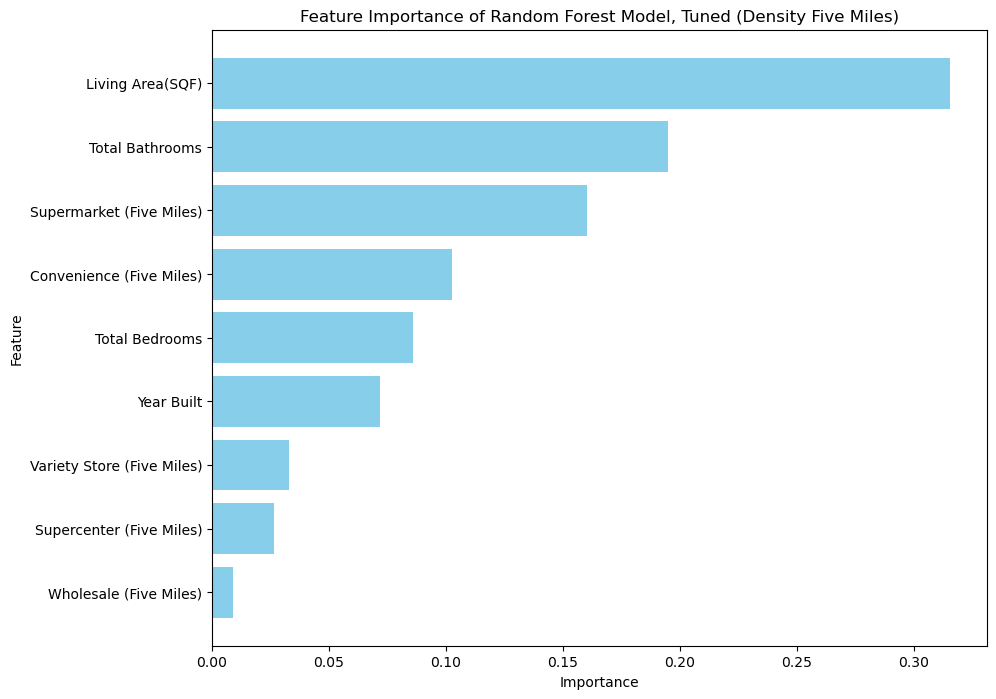

In [51]:
# Create a bar chart for feature importance
plt.figure(figsize=(10, 8))
plt.barh(sorted_feature_names_five, sorted_feature_importances_five, color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance of Random Forest Model, Tuned (Density Five Miles)')
plt.gca().invert_yaxis()  # Invert y-axis to show the most important feature at the top
plt.show()

#The feature importance scores remain consistent regardless of the dataset.

In [52]:
all_feature_names_five

['Year Built',
 'Total Bedrooms',
 'Living Area(SQF)',
 'Convenience (Five Miles)',
 'Supercenter (Five Miles)',
 'Supermarket (Five Miles)',
 'Variety Store (Five Miles)',
 'Wholesale (Five Miles)',
 'Total Bathrooms']

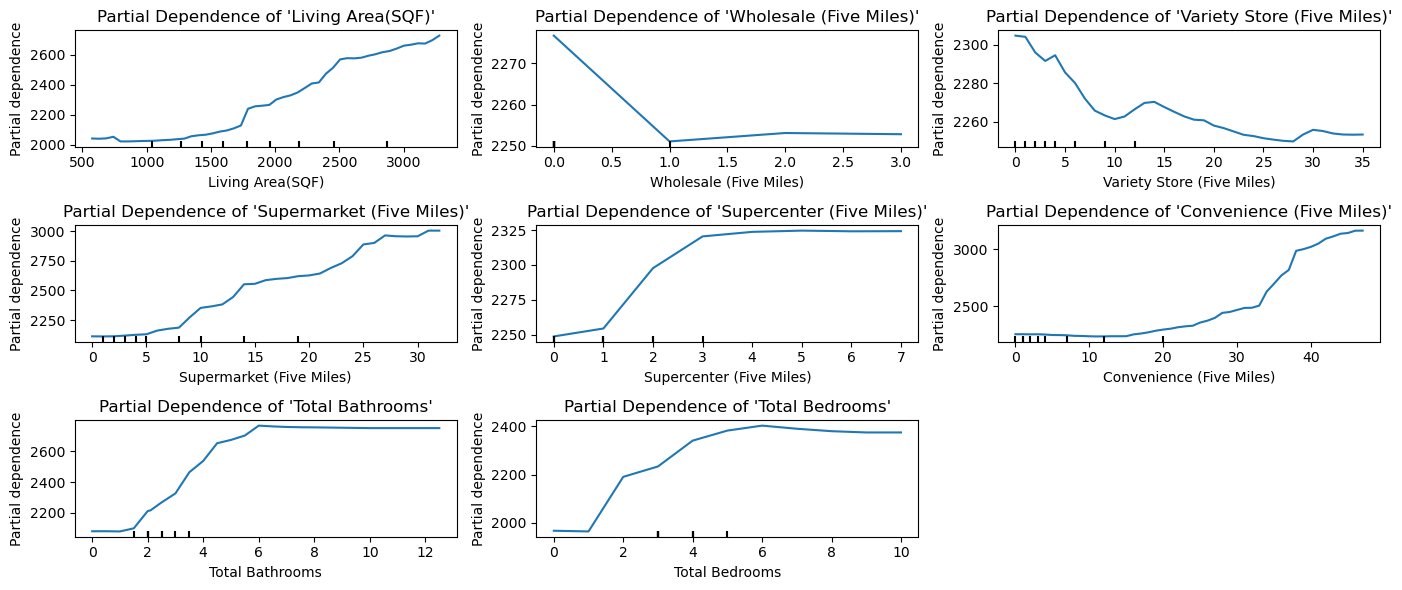

In [53]:
# List of features to include in the Partial Dependence Plots
features = [
 'Living Area(SQF)', 'Wholesale (Five Miles)', 'Variety Store (Five Miles)', 'Supermarket (Five Miles)', 
    'Supercenter (Five Miles)', 'Convenience (Five Miles)', 'Total Bathrooms', 'Total Bedrooms']

# Set the number of rows and columns for the grid
n_features = len(features)
n_cols = 3  # Number of columns in the grid
n_rows = math.ceil(n_features / n_cols)  # Number of rows

# Create subplots in a grid layout
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(14, n_rows * 2))

# Flatten axes for easy iteration
axes = axes.ravel()

# Loop through each feature and plot
for i, feature in enumerate(features):
    PartialDependenceDisplay.from_estimator(
        best_model_five,
        X_train_val_five,  # train data?
        [feature],
        grid_resolution=50,
        ax=axes[i]
    )
    axes[i].set_title(f"Partial Dependence of '{feature}'")  # Set title for each plot

# Hide any empty subplots (if n_features is not a perfect square)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout to avoid overlap
plt.tight_layout()
plt.show()